# PHY426 Term Project: Frequencies in Music
Juan Castaneda, Mohamed Salama

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

# "Some magic to see better quality graphs" - Practical 6
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (9, 7)

# Helper Functions

In [38]:
def major_chord(note):
    '''
    Returns the major chord triad given the root note by using the scale generated from the circle of fifths
    
    The major chord is composed of the root note, the major third and the perfect fifth
    '''
    
    # Note that the scale() function doesn't give the scale in the correct order, but in the order the notes appear
    # on the circle of fifths, which is why, for example, the major third is the 6th element in the list returned by scale()
    
    root = [scale(note)[1]] # root note (first note in the scale)
    third = [scale(note)[5]] # major third (third note in the scale)
    fifth = [scale(note)[2]]  # perfect fifth (fifth note in the scale)
    
    return root + third + fifth

def identify_root(notes):
    '''
    Given 3 notes of a major chord (in any order) identify the chord and return the root note
    '''
    
    for chord in all_major_chords:
        if (set(notes)) == set(chord): # Compares the list of notes to all chords (using set to ignore order)
            return chord[0]  # return the root note of the chord

def freqToNote(freqList):
    '''
    Given a list of frequencies (in the range from about 110 Hz to about 440 Hz), return a list of the names of the notes
    corresponding to each frequency.
    '''
    
    # list of the frequencies and the corresponding note names
    frequencies = [110,116.54,123.47,130.81,138.59,146.83,155.56,164.81,174.61,185,196,207.65,220,233.08,246.94,261.63,277.18,293.66,311.13,329.63,349.23,369.99,392,415.3,440]
    notes = ['A','Bb','B','C','Db','D','Eb','E','F','Gb','G','Ab']*2 + ['A']
    
    note_names = []
    
    # compare each given frequency to the known frequencies
    for freq in freqList:
        for f in frequencies:
            if abs(f-freq) <= 4:  # if the given frequency is within 4 Hz of the known frequency of a note, it is considered equal to that note (this is an arbitrary threshold)
                note_names.append(notes[frequencies.index(f)])
                break
    return note_names

def removeOvertones(freq, amp, fund_freq):
    '''
    Removes overtones of the fundamental frequency (fund__freq) from an array of frequencies (freq) with amplitudes amp
    '''
     
    # loop through frequencies
    for i,f in enumerate(freq):
        
        # check if the frequency is an overtone (or very close) and remove it if it is
        for n in range(1, 10):  #for simplicity, we just remove the first eight overtones (higher overtones will have very low amplitudes, if they are even in the range of frequencies recorded)
            if np.abs((f/n) - fund_freq) <= 10:
                #print("removed", f)
                amp[i] = 0.0 
    
    return amp


def checkFundamental(freq, amp, fund_freq, main_amp):
    '''
    Check if fund_freq/2 or fund_freq/3 are the true fundamental frequency. Return the true fundamental frequency
    
    '''
    for n in range(2, 4):  # check if fund_freq/2 or fund_freq/3 are the true fundamental frequency
        
        # go through amplitudes
        for i in range(len(main_amp)):
            
            # if amplitude is above the threshold, get the corresponding frequency
            if main_amp[i] != 0:  
                new_freq = freq[i]
                
                # check if this is the true fundamental frequency
                if np.abs(new_freq - fund_freq/n) <= 5:
                    return new_freq

    return fund_freq

def score(root,note,worst,bad,better):
    '''
    Returns a probability:
    
    If the note is in the scale of the root return 1 (100%)
    
    Otherwise return probabilities of worst,bad,better depending on its position in the circle of fifths
    Worst,bad,better are related to the disonnance of a note with respect to the scale
    
    '''
    # Probabilities of accepting a note
    
    if note in scale(root):
        return 1 # Return 1 if the note is in the major scale of the root
    else:
        left_most = scale(root)[0]
        right_most = scale(root)[-1]
        
        if distance(right_most,note) ==1: return worst # Tritone
        else:
            dist = min(distance(left_most,note),distance(right_most,note)-1)
            if dist == 2:
                return bad
            if dist == 1:
                return better

            
def distance(root,note):
    '''
    Returns the distance from note to root on the circle of fifths
    '''
    circle = ['C', 'G', 'D', 'A', 'E', 'B', 'Gb', 'Db', 'Ab', 'Eb', 'Bb', 'F']
    distance = abs(circle.index(root)-circle.index(note))
    if distance > 7:
        distance = 12 - distance
    return distance

def scale(note):
    '''
    Extracts the notes for the major scale from the given root note using the circle of fifths 
    '''
    circle = ['C', 'G', 'D', 'A', 'E', 'B', 'Gb', 'Db', 'Ab', 'Eb', 'Bb', 'F']
    circle = circle*2 # Double the list of notes to make finding the notes easier 
    rootIndex = circle.index(note) # Find the index of the root note 
    scale = [circle[rootIndex-1]] + circle[rootIndex:rootIndex+6] # Create the scale
    return scale
        
# Some global variables:

# Circle of fifths
circle = ['C', 'G', 'D', 'A', 'E', 'B', 'Gb', 'Db', 'Ab', 'Eb', 'Bb', 'F']

# Create all major chords by looping looping through each note and calling our major_chord function on it
all_major_chords = [major_chord(root) for root in circle]


# Main Program

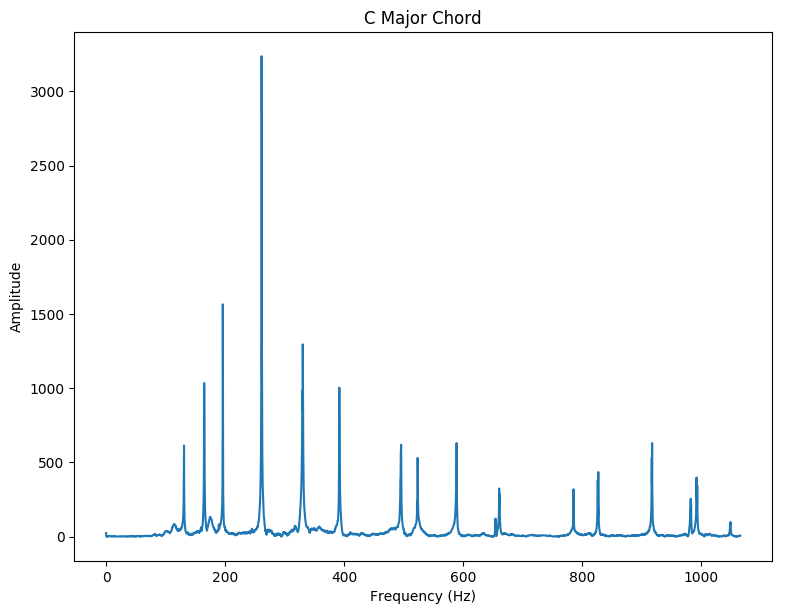

(['C', 'E', 'G'], ['D', 'F', 'Bb', 'Db', 'G', 'D', 'F', 'F'])


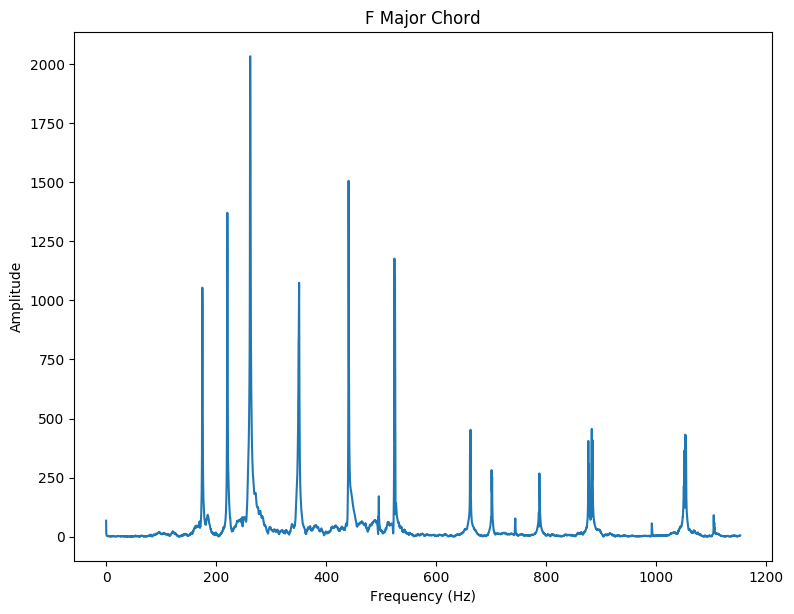

(['F', 'A', 'C'], ['Gb', 'A', 'Eb', 'A', 'Ab', 'B', 'D', 'Db'])


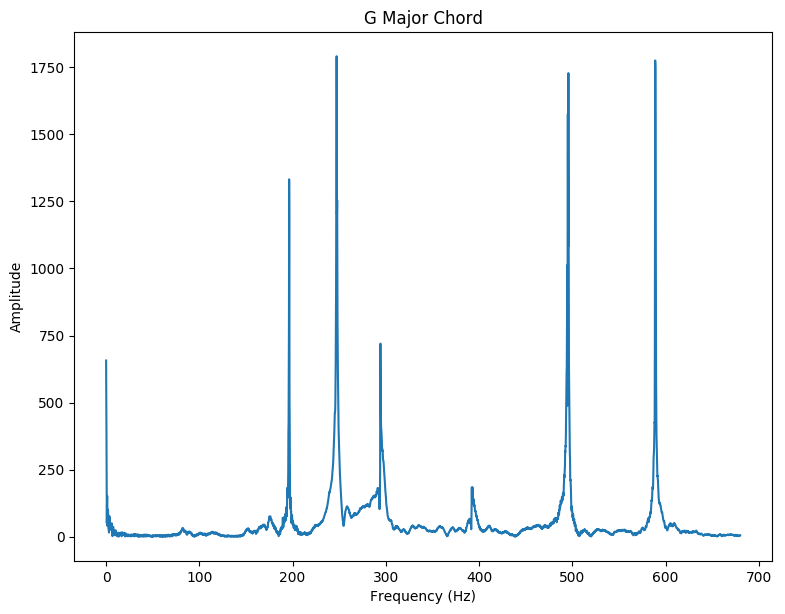

(['G', 'B', 'D'], ['Gb', 'Db', 'C', 'D', 'A', 'G', 'B', 'B'])


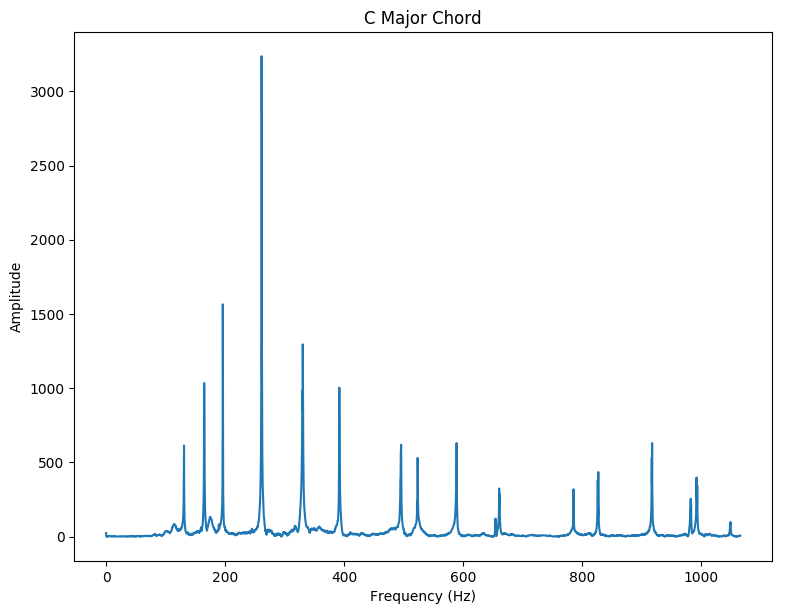

(['C', 'E', 'G'], ['B', 'B', 'Db', 'D', 'Db', 'Ab', 'F', 'Db'])


In [50]:
def Identify(fileName):
    '''
    Identifies the chord in the file with name fileName using Fourier analysis.
    
    Returns the chord (list of the notes in the major triad), the root note, and the duration the chord 
    plays for (ie. length of the wav file) in seconds
    '''
    
    # Read the .wav file to get the sampling rate and the data contained in the file
    sampFreq, sound = wavfile.read(fileName)

    
    # From practical 6:
    
    #    sound.dtype = 'int16'means that the sound pressure values are mapped to integer values that can range from -2^15 to (2^15)-1. The samples are taken 44100 times per second.
    
    #    We can convert our sound (numpy) array to floating point values ranging from -1 to 1 as follows:
    sound = sound / 2.0**15 


    # Duration of the chord (in seconds):
    duration = sound.shape[0] / sampFreq


    # practical 6: To get the proper time on the x-axis we have to generate a numpy array using sampFreq:
    time = np.arange(sound.shape[0]) / sound.shape[0] * duration

    # select a single channel:
    signal = sound[:,0] 

    # Find the amplitude and frequency
    fft_spectrum = np.fft.rfft(signal)
    amp = np.abs(fft_spectrum)
    freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
    
    # Plot the frequencies    
    f1 = plt.figure()
    plt.plot(freq[:3500], amp[:3500])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")

    
    threshold = np.max(amp)/5    
    
    # amplitudes that are above the threshold
    main_amp = np.where(amp>threshold, amp, 0)  # similar to amp, but amplitudes of all frequencies that are below the threshold are set to zero
    
    
    fund = []
    
    # Finding the three fundamental frequencies
    for i in range(3):
        # Getting the next fundamental frequency
        max_index = np.argmax(amp)
        fund_freq = freq[max_index]
        
        #sometimes the highest amplitude didn't correspond to the fundamental frequency, so we have to 
        # make sure that fund_freq is really the fundamental frequency,, and if not, get the true fundamental frequency
        fund_freq = checkFundamental(freq, amp, fund_freq, main_amp)
        


        # remove overtones of the fundamental frequency (so that the remaining frequency with the highest amplitude is the
        #                                                      fundamental frequency of the next note in the chord)        
        amp = removeOvertones(freq, amp, fund_freq)
        
        fund.append(fund_freq)
    
    # get names of notes from fundamental frequencies
    notes = freqToNote(fund)
    
    # identify the chord and the root node
    root = identify_root(notes)
    chord = major_chord(root)
    
    # now that the chord is known, display the plot along with the chord name
    plt.title(root + " Major Chord")
    plt.show()
    
    # Save figure to PDF (need to download it from jupyterhub for pdf to display properly)
    with PdfPages(root + " Major Chord Frequencies.pdf") as pp:
        pp.savefig(f1)
    
    return chord,root, duration

#print(Identify('Chords/C.wav'))



def createMelody(fileName, numNotes,worst,bad,better):
    '''
    Creates an "improvised" melody, containing numNotes number of notes over the chord contained in fileName (which is a .wav file). 
     
    The variables worst, bad, and better are the probabilities that the algorithm will reject notes that are not in the major 
    scale of the chord's root note (if a note in the scale is selected, it is always accepted). 
    Based on their location on the circle of fifths, notes outside the major scale are ranked as worst, bad, or better (this
    has to do with the probability that they will be dissonant to notes that are in the scale)
    
    For simplicity we stick to Major chords and Major scales
    
    Returns the chord, and the notes of the "improvised" melody
    '''
    
    
    # Identifying the chord in fileName, along with its root note and duration in seconds
    chord, root, duration = Identify(fileName)
    
    
    #frequencies = [220,233.08,246.94,261.63,277.18,293.66,311.13,329.63,349.23,369.99,392,415.3]
    notes = ['A','Bb','B','C','Db','D','Eb','E','F','Gb','G','Ab']
    melody = []
    
    
    i = 0
    while i < numNotes:
        randi = np.random.randint(len(notes))
        note = notes[randi]
  
        scoring = score(root,note,worst,bad,better)
        if scoring > np.random.random():
            melody.append(note)
            i += 1
    
    return chord, melody


# Create a melody over the chord progression C, F, G, C:
print(createMelody('C.wav',8,1,1,1))
print(createMelody('F.wav',8,1,1,1))
print(createMelody('G.wav',8,1,1,1))
print(createMelody('C.wav',8,1,1,1))





# Generating Plots to Discuss Dissonance

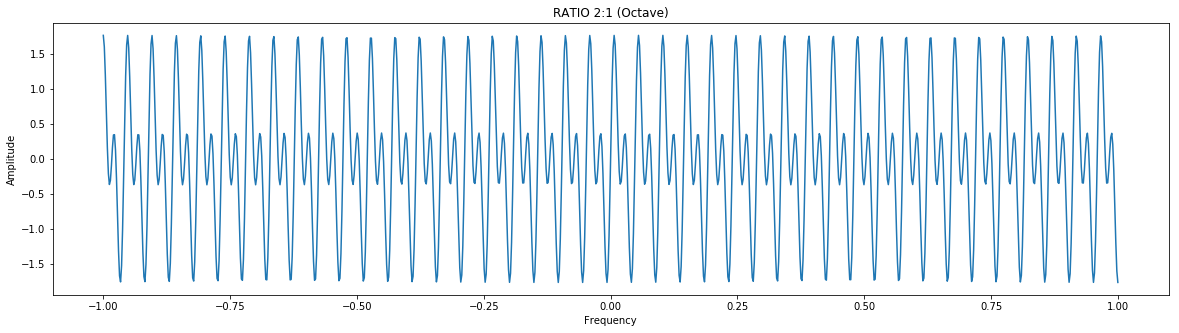

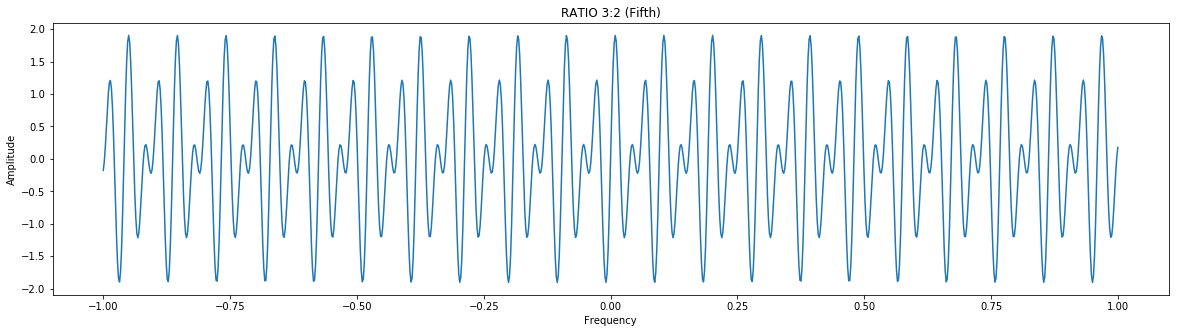

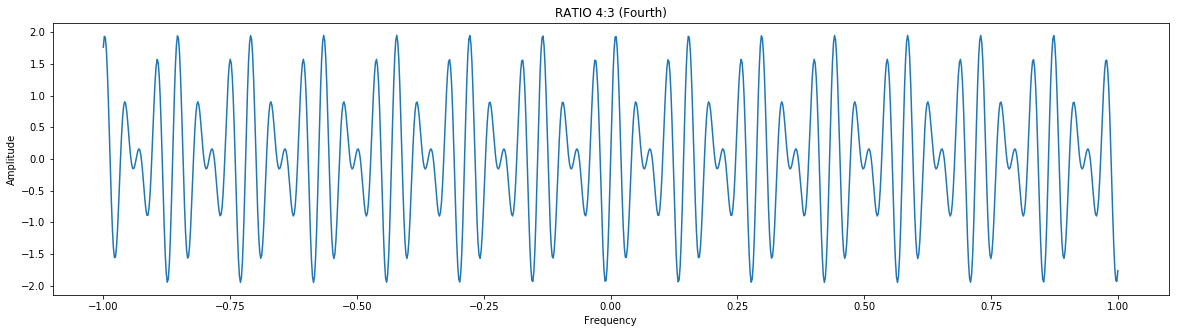

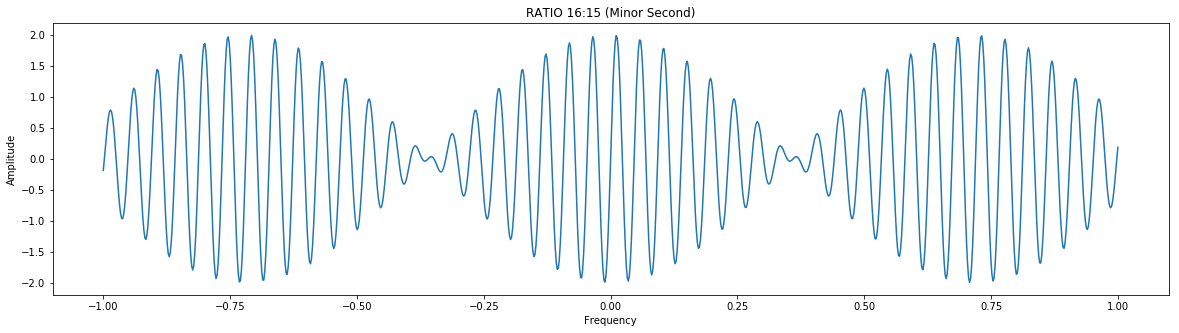

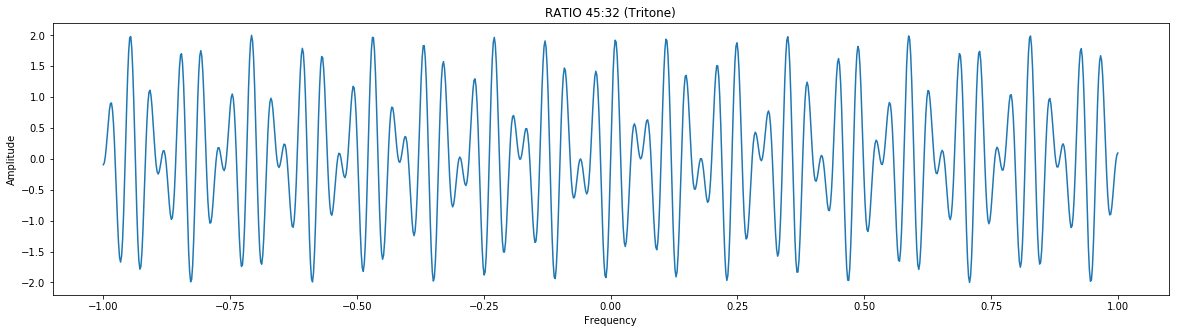

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

# Frequency of C3:
freq_C = 131


# The frequencies for the notes below are created using the ratios of intervals starting from the C3 note

# The plots are then generated by adding their sine waves with their respective frequencies


# The interval fractions, ratios and names
interval_ratios = [2,3/2,4/3,16/15,45/32]
interval_ratios_ = ['2:1','3:2','4:3','16:15','45:32']
interval_names = ['Octave','Fifth','Fourth','Minor Second','Tritone']

# create plots and save to pdf
with PdfPages('Ratios.pdf') as pp:

    for interval in range(len(interval_ratios)):

        int_ratio = interval_ratios[interval] #The current interval ratio

        freq_new = freq_C*int_ratio # The frequency of the note calculated from by scaling the root note by a ratio

        x = np.linspace(-1,1,1000)
        C = np.sin(freq_C*x)
        new_note = np.sin(freq_new*x) # The curve for the new_note using the new frequency 

        f = plt.figure(figsize=(20,5))
        plt.plot(x, C+new_note) # Adding the wave of both notes ('playing' them together)
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        plt.title('RATIO '+ interval_ratios_[interval] + ' ('+interval_names[interval]+ ')')
        plt.show()
        pp.savefig(f)

##############################################################################################
# NOTE: the pdf doesn't open properly in Jupyterhub, but if you download it it should be fine
##############################################################################################